In [16]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import random
import numpy as np
from collections import defaultdict

# Constants and Configurations
ACTIONS = [(0, 0), (-1, 0), (1, 0), (0, -1), (0, 1)]  # Stay, Up, Down, Left, Right
ACTION_NAMES = ['Stay', 'Up', 'Down', 'Left', 'Right']
NUM_ACTIONS = len(ACTIONS)
GAMMA = 0.9
ALPHA = 0.1
EPSILON = 0.2
MAX_EPISODES = 1000
MAZE_SIZE = 10
AGENT_COLORS = ['red', 'blue', 'green', 'purple']
DESTINATIONS = [(1, 5), (5, 8), (5, 1), (8, 4)]


In [17]:

class MazeSimulator:
    """Class to manage maze structure and initialize agents and destinations."""
    def __init__(self, size, walls, num_agents, destinations):
        self.size = size
        self.grid = np.zeros((size, size), dtype=int)
        self.walls = walls
        self.destinations = destinations
        self.num_agents = num_agents
        self.agents = []
        self._initialize_maze()

    def _initialize_maze(self):
        """Set up walls and destinations."""
        for wall in self.walls:
            self.grid[wall] = 1  # Mark walls
        for dest in self.destinations:
            self.grid[dest] = 3  # Mark destinations

    def randomize_agents(self):
        """Randomize agents' starting positions."""
        self.agents = []
        while len(self.agents) < self.num_agents:
            x, y = random.randint(0, self.size - 1), random.randint(0, self.size - 1)
            if self.grid[x, y] == 0:  # Empty cell
                self.agents.append((x, y))

    def get_maze(self):
        return self.grid


class MultiAgentMazeSolver:
    """Class to handle agent movement and Q-learning."""
    def __init__(self, maze, simulator):
        self.maze = maze
        self.simulator = simulator
        self.agents = simulator.agents
        self.destinations = simulator.destinations
        self.num_agents = len(simulator.agents)
        self.state = tuple(simulator.agents)
        self.steps_taken = [0] * self.num_agents

    def is_valid_position(self, pos):
        x, y = pos
        return 0 <= x < MAZE_SIZE and 0 <= y < MAZE_SIZE and self.maze[x, y] != 1

    def reset(self):
        self.simulator.randomize_agents()
        self.agents = self.simulator.agents
        self.state = tuple(self.agents)
        self.steps_taken = [0] * self.num_agents
        return self.state

    def step(self, actions):
        next_state = list(self.state)
        rewards = []
        for i, action in enumerate(actions):
            current_pos = self.state[i]
            move = ACTIONS[action]
            new_pos = (current_pos[0] + move[0], current_pos[1] + move[1])

            if self.is_valid_position(new_pos) and new_pos not in next_state:
                next_state[i] = new_pos

            self.steps_taken[i] += 1
            reward = 10 if next_state[i] == self.destinations[i] else -1
            rewards.append(reward)

        self.state = tuple(next_state)
        done = all(next_state[i] == self.destinations[i] for i in range(self.num_agents))
        return self.state, rewards, done, max(self.steps_taken)

    def train_agents(self):
        q_tables = [defaultdict(lambda: np.zeros(NUM_ACTIONS)) for _ in range(self.num_agents)]
        min_max_time = float('inf')
        rewards_history = []
        steps_history = []

        for episode in range(MAX_EPISODES):
            state = self.reset()
            done = False
            cumulative_rewards = 0
            steps = 0

            while not done:
                actions = [
                    np.random.choice(NUM_ACTIONS) if np.random.rand() < EPSILON else np.argmax(q_tables[i][state[i]])
                    for i in range(self.num_agents)
                ]

                next_state, rewards, done, max_time = self.step(actions)

                for i in range(self.num_agents):
                    current_q = q_tables[i][state[i]][actions[i]]
                    next_max_q = np.max(q_tables[i][next_state[i]])
                    q_tables[i][state[i]][actions[i]] = current_q + ALPHA * (
                        rewards[i] + GAMMA * next_max_q - current_q
                    )

                cumulative_rewards += sum(rewards)
                steps += 1
                state = next_state

            min_max_time = min(min_max_time, max_time)
            rewards_history.append(cumulative_rewards)
            steps_history.append(steps)

        return q_tables, min_max_time, rewards_history, steps_history

    def visualize_maze(self):
        fig, ax = plt.subplots(figsize=(8, 8))
        for x in range(MAZE_SIZE):
            for y in range(MAZE_SIZE):
                if self.maze[x, y] == 1:
                    ax.add_patch(patches.Rectangle((y, MAZE_SIZE - x - 1), 1, 1, color='brown'))
                elif self.maze[x, y] == 3:
                    agent_index = self.destinations.index((x, y))
                    color = AGENT_COLORS[agent_index]
                    ax.plot(y + 0.5, MAZE_SIZE - x - 1 + 0.5, marker='x', color=color, markersize=15, markeredgewidth=3)

        for i in range(MAZE_SIZE + 1):
            ax.plot([0, MAZE_SIZE], [i, i], color='black', linewidth=0.5)
            ax.plot([i, i], [0, MAZE_SIZE], color='black', linewidth=0.5)

        ax.set_aspect('equal')
        ax.axis('off')
        plt.title("Maze Layout")
        plt.show()

    def visualize_paths(self, q_tables):
        fig, ax = plt.subplots(figsize=(8, 8))
        for x in range(MAZE_SIZE):
            for y in range(MAZE_SIZE):
                if self.maze[x, y] == 1:
                    ax.add_patch(patches.Rectangle((y, MAZE_SIZE - x - 1), 1, 1, color='brown'))
                elif self.maze[x, y] == 3:
                    agent_index = self.destinations.index((x, y))
                    color = AGENT_COLORS[agent_index]
                    ax.plot(y + 0.5, MAZE_SIZE - x - 1 + 0.5, marker='x', color=color, markersize=15, markeredgewidth=3)

        for i in range(self.num_agents):
            current_pos = self.agents[i]
            destination = self.destinations[i]
            while current_pos != destination:
                best_action_index = np.argmax(q_tables[i][current_pos])
                move = ACTIONS[best_action_index]
                next_pos = (current_pos[0] + move[0], current_pos[1] + move[1])
                ax.arrow(
                    current_pos[1] + 0.5,
                    MAZE_SIZE - current_pos[0] - 1 + 0.5,
                    move[1] * 0.8,
                    -move[0] * 0.8,
                    head_width=0.2,
                    head_length=0.2,
                    fc=AGENT_COLORS[i],
                    ec=AGENT_COLORS[i],
                )
                current_pos = next_pos

        ax.set_aspect('equal')
        ax.axis('off')
        plt.title("Optimal Paths for Agents")
        plt.show()

    def plot_training_metrics(self, rewards_history, steps_history):
        plt.figure(figsize=(12, 5))
        plt.subplot(1, 2, 1)
        plt.plot(rewards_history, label="Cumulative Rewards")
        plt.xlabel("Episodes")
        plt.ylabel("Cumulative Rewards")
        plt.title("Rewards Over Episodes")
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.plot(steps_history, label="Steps Per Episode", color='orange')
        plt.xlabel("Episodes")
        plt.ylabel("Steps")
        plt.title("Steps Over Episodes")
        plt.legend()

        plt.tight_layout()
        plt.show()


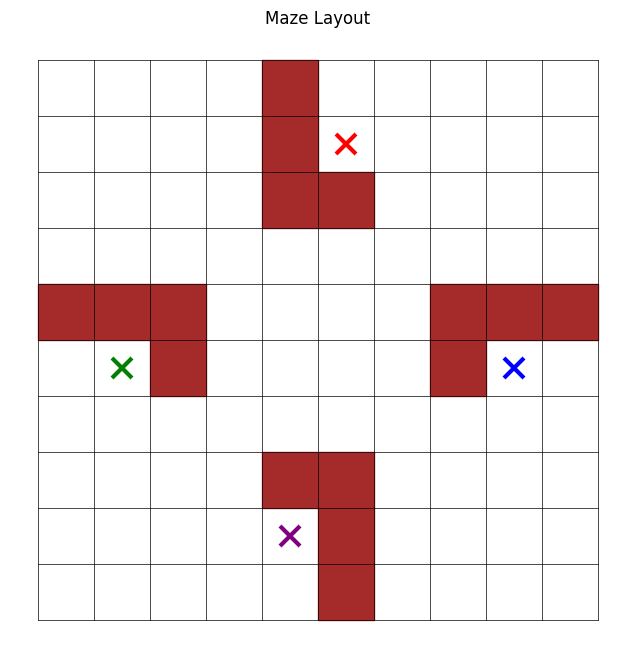

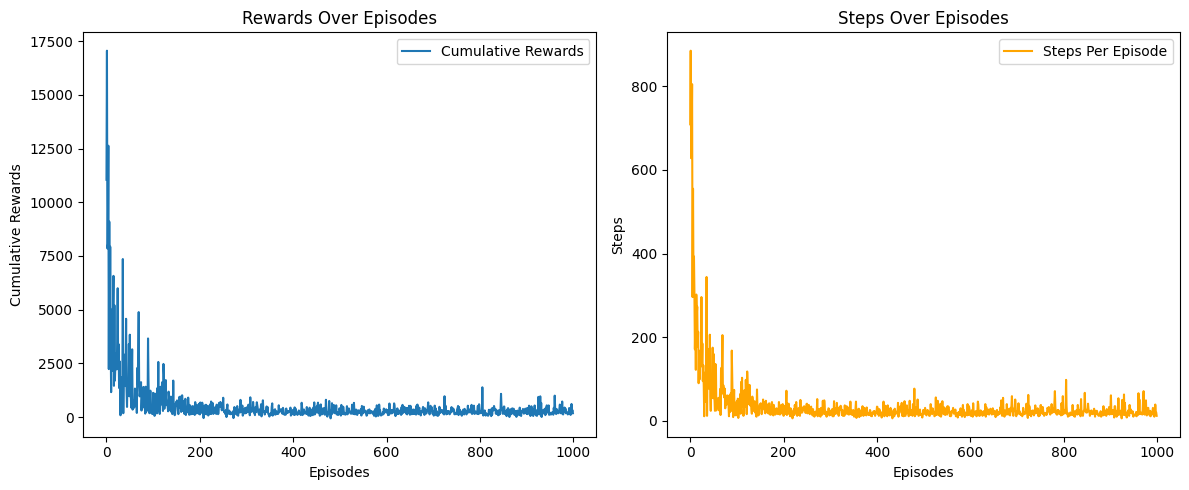

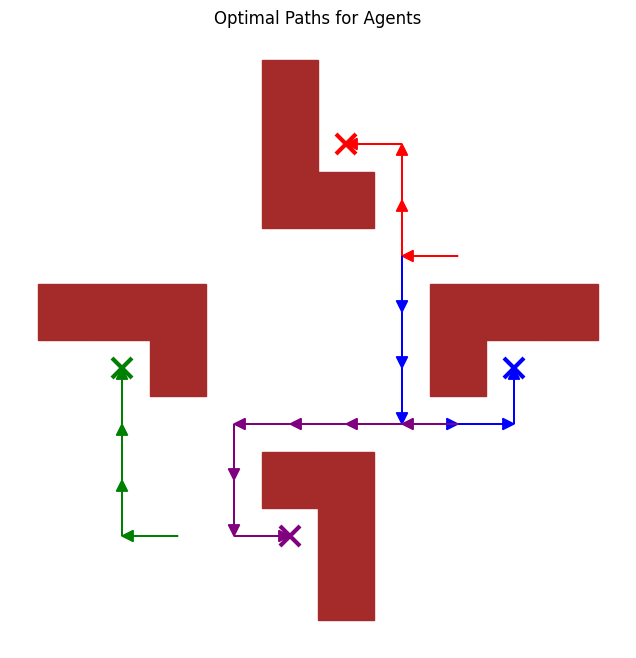

Minimum time for all agents to reach their destinations: 6 steps


In [18]:
if __name__ == "__main__":
    # Initialize the maze and solver
    walls = [
        (0, 4), (1, 4), (2, 4), (2, 5), (4, 7), (4, 8), (4, 9), (5, 7),
        (4, 0), (4, 1), (4, 2), (5, 2), (7, 5), (8, 5), (9, 5), (7, 4)
    ]
    simulator = MazeSimulator(MAZE_SIZE, walls, len(DESTINATIONS), DESTINATIONS)
    simulator.randomize_agents()
    maze = simulator.get_maze()

    solver = MultiAgentMazeSolver(maze, simulator)

    # Visualize the initial maze layout
    solver.visualize_maze()

    # Train agents using Q-learning
    q_tables, min_max_time, rewards_history, steps_history = solver.train_agents()

    # Visualize the training metrics
    solver.plot_training_metrics(rewards_history, steps_history)

    # Visualize the optimal paths for the agents
    solver.visualize_paths(q_tables)

    # Print the minimum time for all agents to reach their destinations
    print(f"Minimum time for all agents to reach their destinations: {min_max_time} steps")
